In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from discoutils.thesaurus_loader import Vectors as vv

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


In [2]:
def _ws353():
    return pd.read_csv('../thesisgenerator/similarity-data/wordsim353/combined.csv',
                       names=['w1', 'w2', 'sim'])

def _mc():
    return pd.read_csv('../thesisgenerator/similarity-data/miller-charles.txt',
                       names=['w1', 'w2', 'sim'], sep='\t')

def _rg():
    return pd.read_csv('../thesisgenerator/similarity-data/rub-gooden.txt',
                       names=['w1', 'w2', 'sim'], sep='\t')

def _men():
    df = pd.read_csv('../thesisgenerator/similarity-data/MEN/MEN_dataset_lemma_form_full',
                       names=['w1', 'w2', 'sim'], sep=' ')
    def _convert_tag(word):
        return '%s/%s'%(word[:-2], word[-1].upper())
    df.w1 = df.w1.map(_convert_tag)
    df.w2 = df.w2.map(_convert_tag)
    return df

def datasets():
    yield 'ws353', _ws353()
    yield 'mc', _mc()
    yield 'rg', _rg()
    yield 'men', _men()

In [5]:
def intrinsic_eval(vectors, df, noise=0, reload=True):
    v = vv.from_tsv(vectors, noise=noise) if reload else vectors
    def get_vector_for(word):
        vectors = []
        if word[-2] == '/':
            # pos tag is there already, let's just do it
            if word in v:
                vectors.append(v.get_vector(word))
        else:
            # what could the pos tag be?
            for pos in 'JNV':
                candidate = '%s/%s'%(word.lower(), pos)
                if candidate in v:
                    vectors.append(v.get_vector(candidate))
        if len(vectors) > 1:
            pass
#             print('multiple vectors for', word, len(vectors))
        return vectors

    model_sims, human_sims = [], []
    missing = 0
    for w1, w2, human in zip(df.w1, df.w2, df.sim):
        v1, v2 = get_vector_for(w1), get_vector_for(w2)
        if v1 and v2:
            model_sims.append(cosine_similarity(v1[0], v2[0])[0][0])
            human_sims.append(human)
        else:
            missing += 1

    relaxed = spearmanr(model_sims, human_sims)[0] # rho, pval 
    
    model_sims += [0]*missing
    human_sims += [0]*missing
    strict = spearmanr(model_sims, human_sims)[0] # rho, pval 

    return strict, relaxed
    

In [6]:
paths = ['../FeatureExtractionToolkit/word2vec_vectors/word2vec-gigaw-100perc.unigr.strings.rep0',
        '../FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-15perc.unigr.strings.rep0',
        '../FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-50perc.unigr.strings.rep0',
        '../FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-100perc.unigr.strings.rep0']
names = ['w2v-giga-100', 'w2v-wiki-15', 'w2v-wiki-50', 'w2v-wiki-100']

data = []

for dname, df in datasets():
    for vname, path in zip(names, paths):
        print('starting', dname, vname, flush=True)
        for noise in np.arange(.2, 2.1, .2): 
            strict, relaxed = intrinsic_eval(path, df, noise)
            data.append((vname, dname, noise, strict, relaxed))

starting ws353 w2v-giga-100
starting ws353 w2v-wiki-15
starting ws353 w2v-wiki-50
starting ws353 w2v-wiki-100
starting mc w2v-giga-100
starting mc w2v-wiki-15
starting mc w2v-wiki-50
starting mc w2v-wiki-100
starting rg w2v-giga-100
starting rg w2v-wiki-15
starting rg w2v-wiki-50
starting rg w2v-wiki-100
starting men w2v-giga-100
starting men w2v-wiki-15
starting men w2v-wiki-50
starting men w2v-wiki-100


In [7]:
df = pd.DataFrame(data, columns=['vect', 'test', 'noise', 'strict_corr', 'relaxed_corr'])

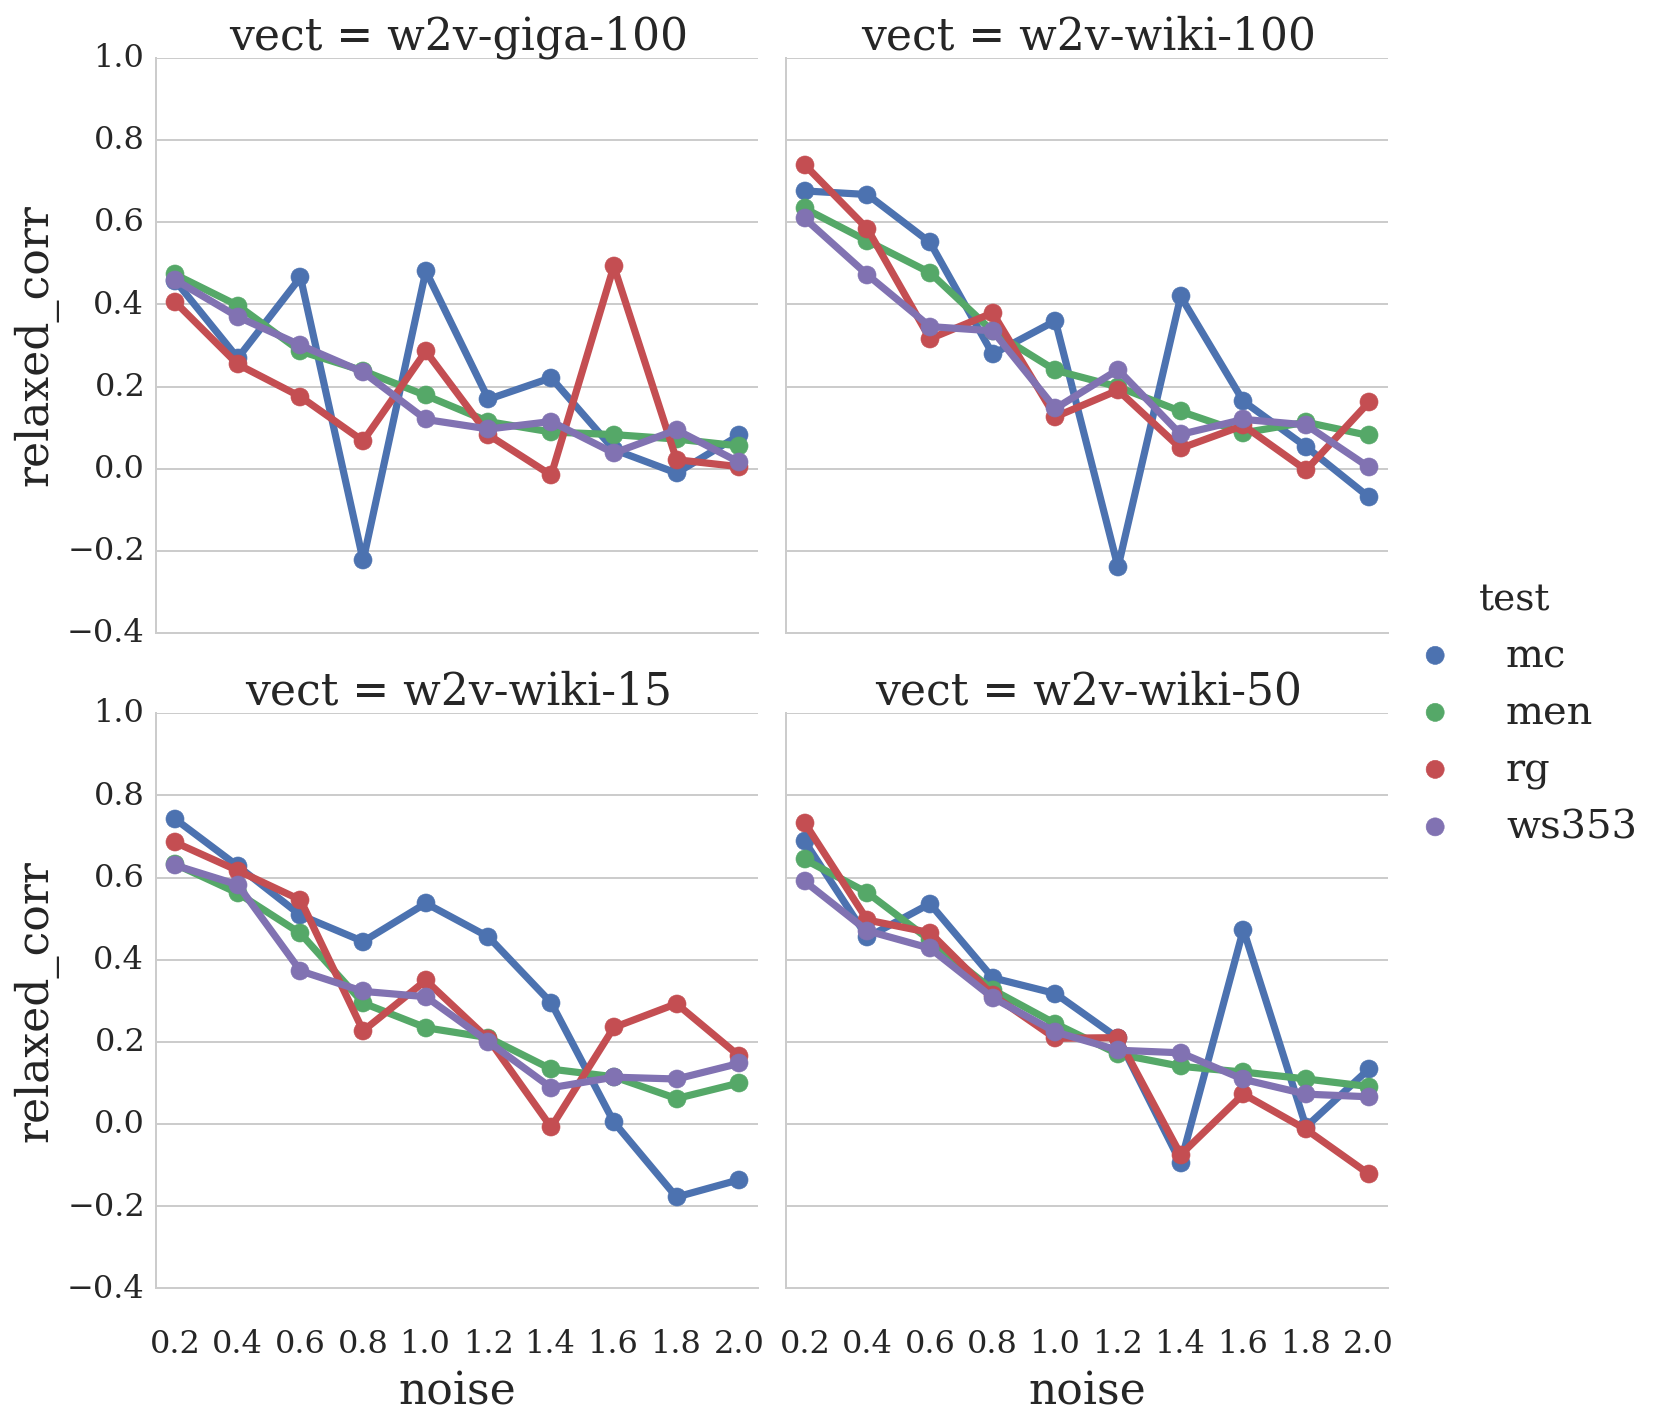

In [8]:
sns.factorplot(x='noise', col='vect', hue='test', y='relaxed_corr', col_wrap=2,
               data=df, kind='point', x_order=sorted(df.noise.unique()));
plt.savefig('plot-intrinsic-eval.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

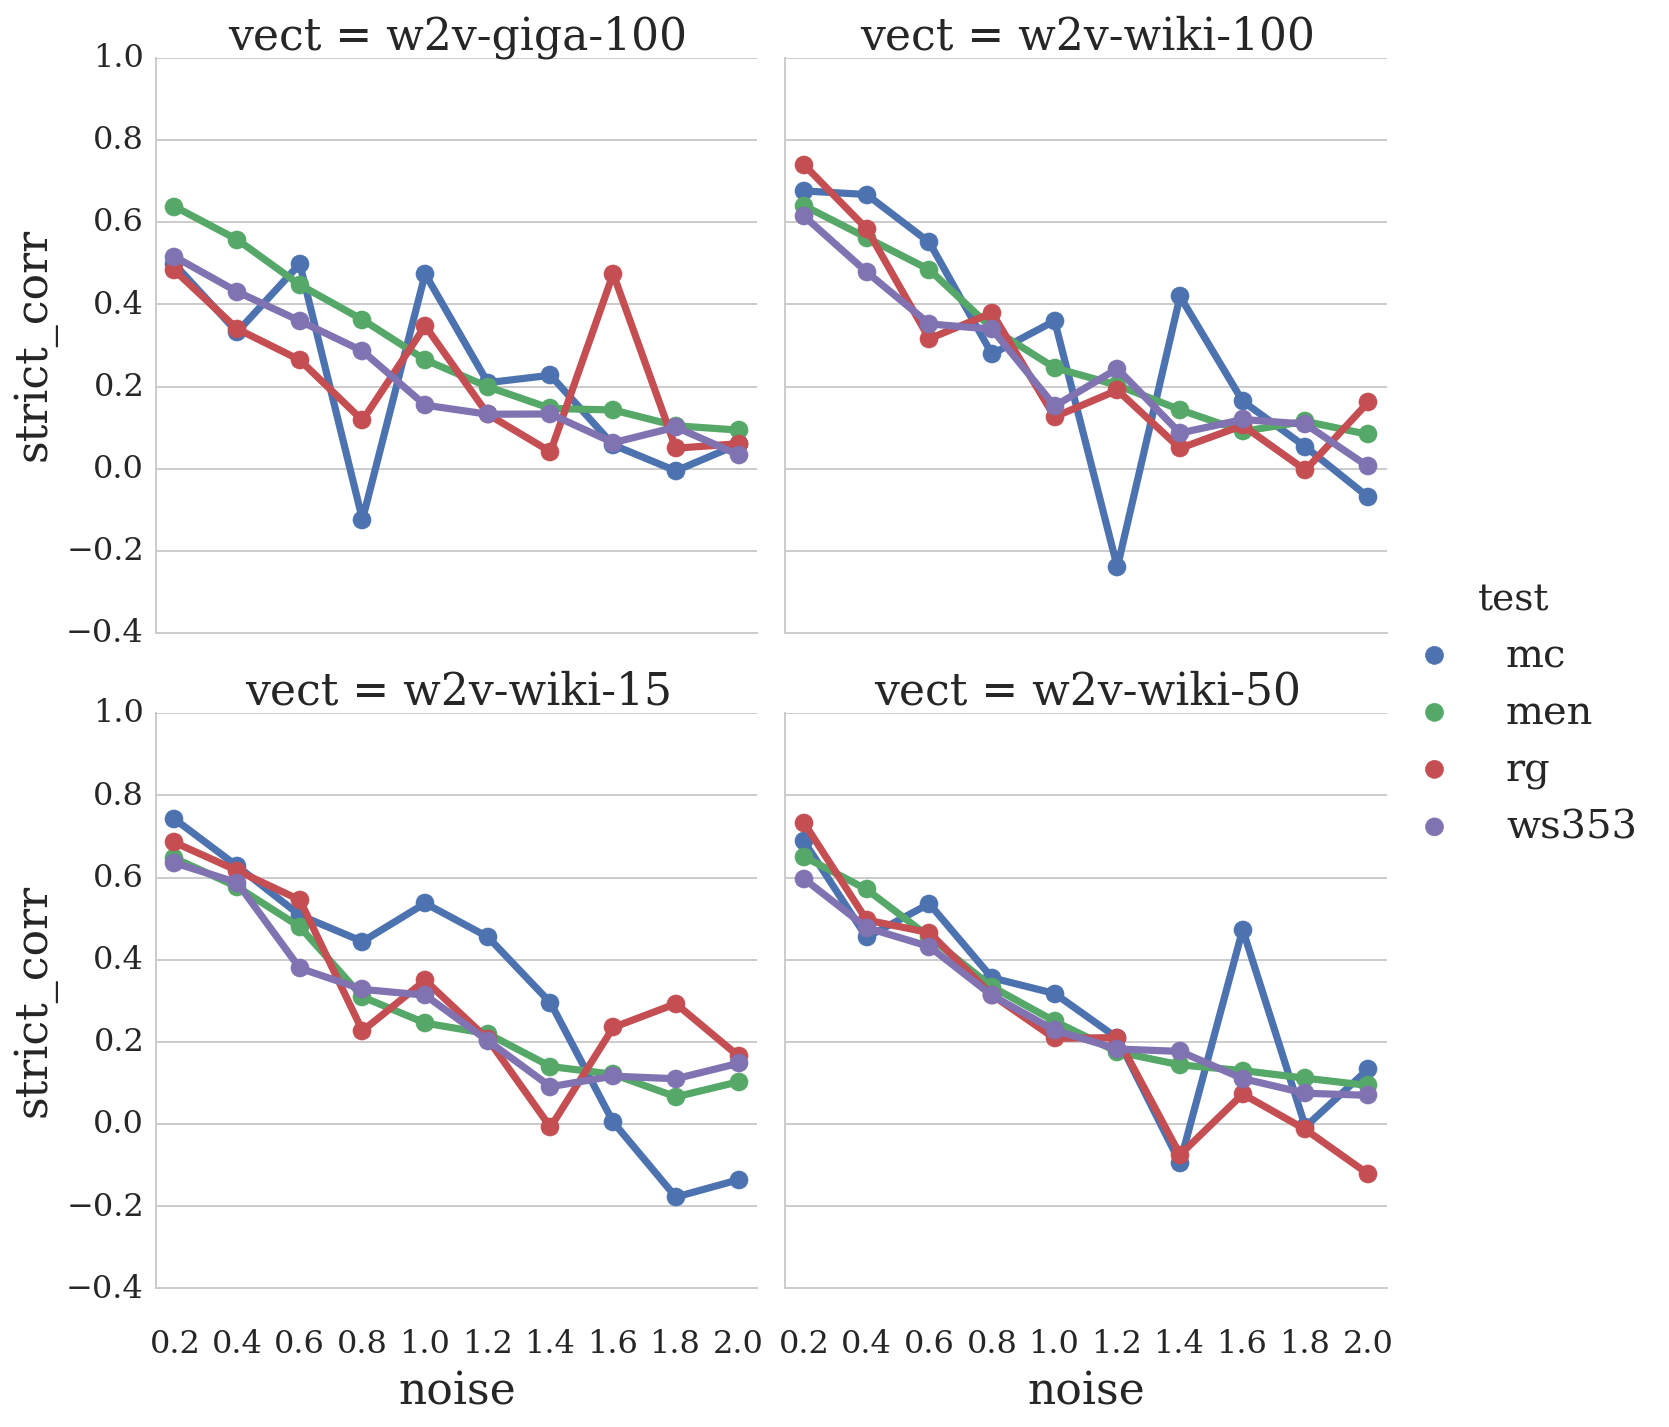

In [9]:
sns.factorplot(x='noise', col='vect', hue='test', y='strict_corr', col_wrap=2,
               data=df, kind='point', x_order=sorted(df.noise.unique()));
plt.savefig('plot-intrinsic-eval-strict.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# State-of-the-art
Bruni, Tran, Baroni (multimodal dist semantics):
 - ws: 0.7
 - men: 0.77
 
Measured vector quality decreases nicely, but cannot tell between `wiki-15` and `wiki-100`. This may be because this is a relaxed test, where OOV items are not looked at. `wiki-15` will have lower coverage of types, so if it scored 0 for each OOV item it would probably have a lower score. 
 - Do people use the strict version?
 - What do I do with multiple possible POS tags per word for `ws353` data?



In [10]:
# learning curve
query_dict = {'expansions__vectors__rep': 0, 
                  'expansions__k':3,
                  'labelled':'amazon_grouped-tagged',
                'expansions__use_similarity': 0, 
                'expansions__neighbour_strategy':'linear',
                'expansions__vectors__dimensionality': 100, 
                'document_features_ev': 'AN+NN', 
                'document_features_tr': 'J+N+AN+NN', 
                'expansions__allow_overlap': False,
                'expansions__entries_of': None,
                #           'vectors__unlabelled_percentage__in': [70,80], # todo remove this
                'expansions__vectors__algorithm': 'word2vec',
                'expansions__vectors__composer': 'Add',
                'expansions__vectors__unlabelled': 'wiki',
                'expansions__decode_handler': 'SignifiedOnlyFeatureHandler',
                'expansions__noise': 0}
experiments = Experiment.objects.filter(**query_dict).order_by('expansions__vectors__unlabelled_percentage')
print([e.id for e in experiments])
data = []
for e in experiments:
    print(e.expansions.vectors.path)
    vectors = vv.from_tsv(e.expansions.vectors.path)
    for dname, df in datasets():
        res = intrinsic_eval(vectors, df, 0, reload=False)
        data.append((e.expansions.vectors.unlabelled_percentage, dname, res))

[114, 115, 72, 116, 117, 118, 88, 119, 120, 121, 122, 123]
/mnt/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/composed/AN_NN_word2vec-wiki_1percent-rep0_Add.events.filtered.strings
/mnt/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/composed/AN_NN_word2vec-wiki_10percent-rep0_Add.events.filtered.strings
/mnt/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/composed/AN_NN_word2vec-wiki_15percent-rep0_Add.events.filtered.strings
/mnt/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/composed/AN_NN_word2vec-wiki_20percent-rep0_Add.events.filtered.strings
/mnt/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/composed/AN_NN_word2vec-wiki_30percent-rep0_Add.events.filtered.strings
/mnt/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/composed/AN_NN_word2vec-wiki_40percent-rep0_Add.events.filtered.strings
/mnt/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/compos

ValueError: setting an array element with a sequence.

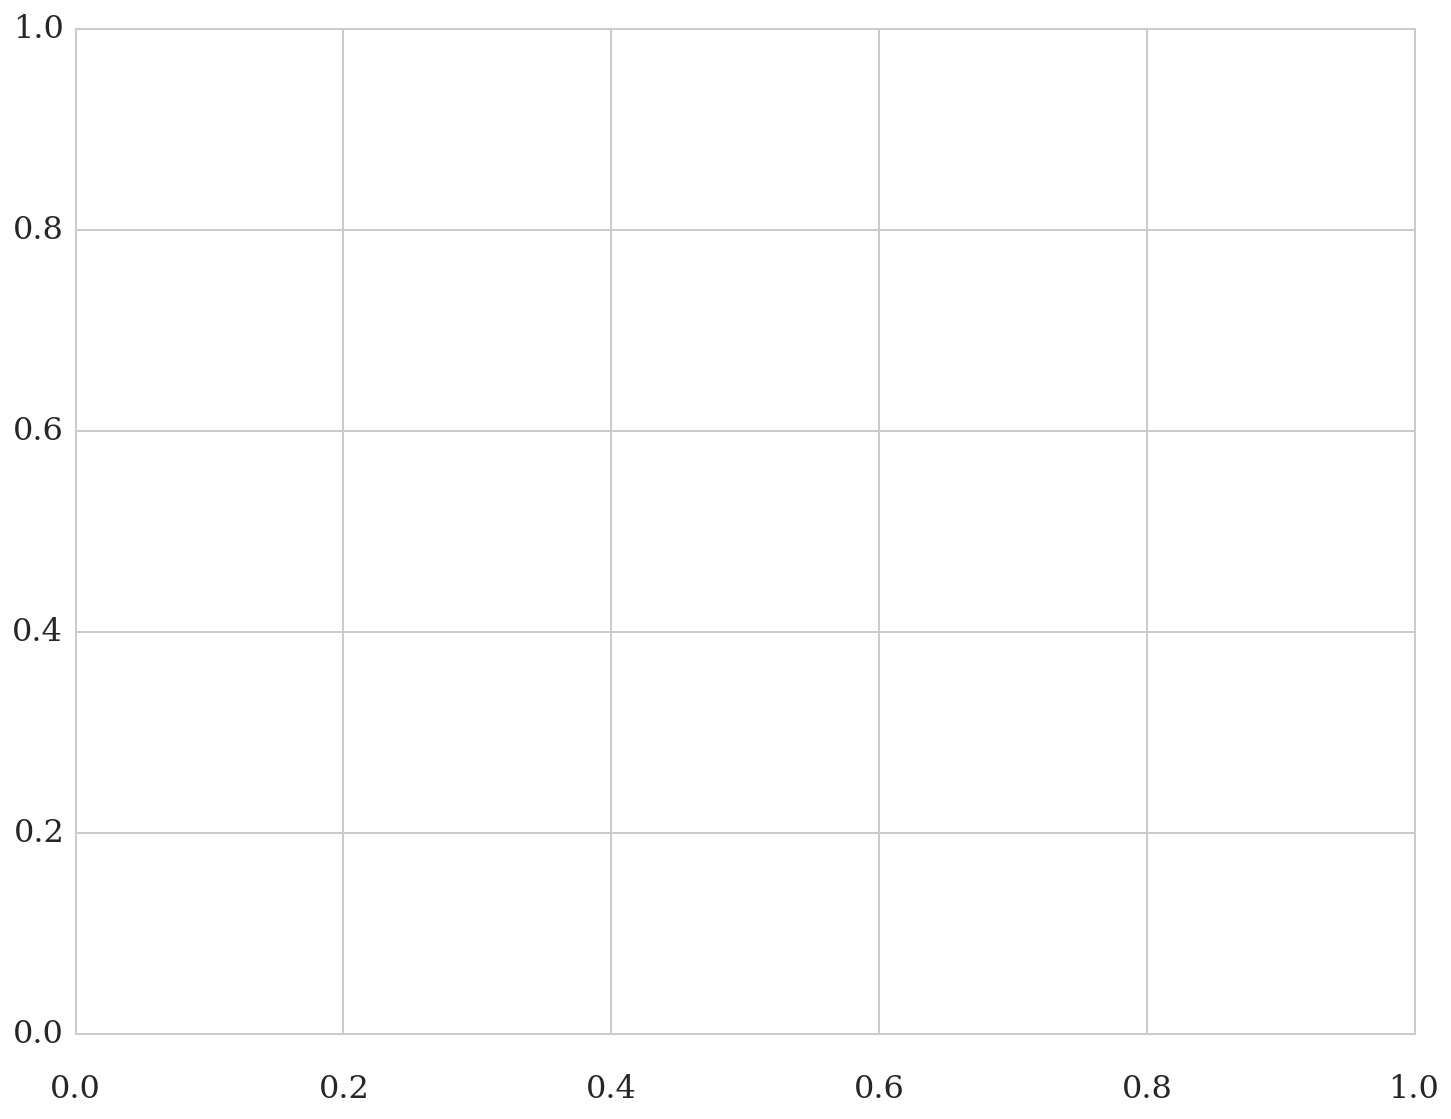

In [11]:
df = pd.DataFrame(data, columns=['percent', 'test', 'corr'])
for name, dfg in df.groupby('test'):
    plt.plot(dfg.percent.values, dfg['corr'].values, label=name)
plt.legend();
plt.savefig('plot-intrinsic-eval2.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)